In [31]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns
from scipy import stats
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from pycaret.regression import *

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [32]:
# ADD TIME FEATURES
def add_time_features(df, time_column):
    
    df[time_column] = pd.to_datetime(df[time_column])  # Make sure the time column is in datetime format
    
    # Extract various time features
    df['hour'] = df[time_column].dt.hour
    df['day_of_week'] = df[time_column].dt.dayofweek
    df['month'] = df[time_column].dt.month
    df['day_of_year'] = df[time_column].dt.dayofyear
    df['week_of_year'] = df[time_column].dt.isocalendar().week 
    df['year'] = df[time_column].dt.year
    #df['sin_hour'] = np.sin(np.pi * df[time_column].dt.hour/24.)
    #df['sin_month'] = np.sin(np.pi * df[time_column].dt.month/12.)
    #pd.set_option('display.max_rows', None)
    #df = df.drop(['hour'])
    #print(df['sin_hour'])
    
    return df

In [33]:
def plot_targets(targets, start_date, end_date):
    # Slice the dataframe based on the provided start and end dates
    targets_subset = targets[(targets['time'] >= start_date) & (targets['time'] <= end_date)]

    # Plotting
    plt.figure(figsize=(15, 6))
    plt.plot(targets_subset['time'], targets_subset['pv_measurement'], label='PV Measurement', color='blue')
    plt.xlabel('Time')
    plt.ylabel('PV Measurement')
    plt.title('PV Measurement Over Time')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [34]:
# PREPROCESSING
def preprocessing(targets, observed, estimated, test):
   #bruk lasso regularisering
   #annen learing rate, 0.0001
    # Ensure the datetime columns are in datetime format
    targets['time'] = pd.to_datetime(targets['time'])
    observed['date_forecast'] = pd.to_datetime(observed['date_forecast'])
    estimated['date_forecast'] = pd.to_datetime(estimated['date_forecast'])
    test['date_forecast'] = pd.to_datetime(test['date_forecast'])
    
    # Resample observed, estimated, and test data to 1 hour using mean() as aggregator
    # and drop rows where all columns are NaN
    # Convert 'time' to datetime if it isn't already
    

# Extract hour and group by it to get the index of maximum value in each group
    '''idx = targets.groupby([targets['time'].dt.date, targets['time'].dt.hour])['pv_measurement'].idxmax()


# Use the indices to get the corresponding rows from the original dataframe
    targets_max = targets.loc[idx].reset_index(drop=True)
    targets_mean = targets.set_index('time').resample('1H').mean().dropna(how='all').reset_index()
    pd.set_option('display.max_rows', None)'''
    #print(targets_max, 'max')
    #print(targets_mean, 'mean')
    

# Assuming you already have your dataframes: observed, estimated, test


    '''def process_data(df):
      # Shift date by 30 minutes
      df['date_forecast'] = df['date_forecast'] + pd.Timedelta(minutes=30)
      
      # Resample to 1H frequency
      resampled = df.set_index('date_forecast').resample('1H').mean().reset_index()
      
      # Drop the last row if it's the last half hour of data
      
      resampled = resampled.iloc[:-1]
      
      return resampled
    pd.set_option('display.max_rows', None)

    
    print(estimated)
    observed_resampled = process_data(observed)
    estimated_resampled = process_data(estimated)
    test_resampled = process_data(test)'''
    #This code will first shift the data by 30 minutes, then resample it into 1-hour intervals, and finally drop the last row if it represents less than a full hour of data.




    
    # Start the resampling from 30 minutes past the hour
    observed_resampled = observed.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    estimated_resampled = estimated.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    test_resampled = test.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    
    is_day_feature = test_resampled[['date_forecast', 'is_day:idx']]
    
    test_resampled = test_resampled.drop(columns =['is_day:idx', 'snow_density:kgm3','elevation:m'])
    observed_resampled = observed_resampled.drop(columns =[ 'is_day:idx', 'snow_density:kgm3','elevation:m'])
    estimated_resampled = estimated_resampled.drop(columns =[ 'is_day:idx', 'snow_density:kgm3','elevation:m'])
    first_date = targets['time'].min()
    last_date = targets['time'].max()
    
    # Printing the results
    print(f"The dataset starts from {first_date} and ends at {last_date}")

    start_date = '2017-07-01'  # Replace with desired start date
    end_date = '2024-08-30'  # Replace with desired end date
    def process_data(observed, estimated, test):
    # Assuming 'date_forecast' is the datetime column for both dataframes.
    
    # 1. Create time-delta for estimated data
      estimated['time_delta'] = (estimated['date_forecast'] - estimated['date_forecast'].dt.normalize()).dt.total_seconds() / 3600
      observed['time_delta'] = 0  # since observed data is not forecasting ahead
      test['time_delta'] = (test['date_forecast'] - test['date_forecast'].dt.normalize()).dt.total_seconds() / 3600
      
      # 2. Add indicator variable for estimated data
      estimated['is_estimated'] = 1
      observed['is_estimated'] = 0
      test['is_estimated'] = 1
      # Merge or concatenate data
      df = pd.concat([observed, estimated], axis=0).sort_values(by='date_forecast')
      print(df['time_delta'])
      return df, test
   
    weather_data, test_resampled = process_data(observed_resampled, estimated_resampled, test_resampled)
    # Merge the observed and estimated data
    #weather_data = pd.concat([observed_resampled, estimated_resampled])

    # Merge with target values
    merged_data = pd.merge(targets, weather_data, how='inner', left_on='time', right_on='date_forecast')
    # Add the time-based features
    merged_data = add_time_features(merged_data, 'time')  
    test_resampled = add_time_features(test_resampled, 'date_forecast') 
    if merged_data.empty:
      print(f"merged_data is empty for location ")
    merged_data = merged_data[merged_data['pv_measurement'] != 0]
    
    # Step 1: Calculate the difference
    merged_data['diff'] = merged_data['pv_measurement'].diff().fillna(0)

    # Step 2: Create an indicator for constant stretches
    merged_data['constant'] = (merged_data['diff'] == 0).astype(int)

    # Step 3: Use the indicator to mark stretches. The diff() function here identifies change-points.
    merged_data['block'] = (merged_data['constant'].diff() != 0).astype(int).cumsum()

    # Get the size of each constant block
    block_sizes = merged_data.groupby('block')['constant'].sum()

    # Identify blocks that are constant for more than 2 consecutive time points (you can adjust this threshold)
    constant_blocks = block_sizes[block_sizes > 2].index

    # Step 4: Remove the constant stretches
    filtered_data = merged_data[~merged_data['block'].isin(constant_blocks)]
    print(targets.dtypes)
    # Clean up auxiliary columns
    targets_ny = filtered_data[ ['time', 'pv_measurement']]
    filtered_data = filtered_data.drop(columns=['diff', 'constant', 'block'])
    
    plot_targets(targets_ny, start_date, end_date)
    if observed_resampled.empty:
      print(f"observed_resampled is empty for location ")
    # Drop non-feature columns
    filtered_data = filtered_data.drop(columns=['time', 'date_forecast', 'pv_measurement'])
    test_resampled = test_resampled.drop(columns=[ 'date_forecast'])
    print(test_resampled.dtypes)
    return filtered_data, test_resampled, is_day_feature, targets_ny

In [35]:
from pycaret.regression import *
def process_location(X, y, location_name):
    # Combine feature data and target into a single DataFrame
    data = X.copy()
    data['target'] = y['pv_measurement']

    # Setup the environment in PyCaret
    exp_reg = setup(data=data, target='target', session_id=123,
                    categorical_features=['dew_or_rime:idx', 'is_in_shadow:idx','is_estimated'],
                    #remove_outliers=True,  #Ble dårligere med denne
                    html=False,
                    #silent=True,
                      
                    experiment_name=f'exp_{location_name}')

    # Create a LightGBM model
    lightgbm = create_model('lightgbm')
    # First, create multiple models
    
    #best = compare_models(n_select = 3)
    # Blend models
    #blended = blend_models(best)

    
    # Tune the model
    tuned_lightgbm = tune_model(lightgbm)#, early_stopping=True, fold=15)
    
    # Create a bagged version of the tuned model
    bagged_lightgbm = ensemble_model(tuned_lightgbm, method='Bagging')
    #boost_lightgbm = ensemble_model(bagged_lightgbm, method='Boosting')
    # Finalize the model - this will train it on the complete dataset
    final_model = finalize_model(bagged_lightgbm)

    # Save the model for future use
    save_model(final_model, f'final_model_for_location_{location_name}')

    return final_model

In [36]:
#help(tune_model)

In [39]:
help(setup)

Help on function setup in module pycaret.regression.functional:

setup(data: Union[dict, list, tuple, numpy.ndarray, scipy.sparse._base.spmatrix, pandas.core.frame.DataFrame, NoneType] = None, data_func: Union[Callable[[], Union[dict, list, tuple, numpy.ndarray, scipy.sparse._base.spmatrix, pandas.core.frame.DataFrame]], NoneType] = None, target: Union[int, str, list, tuple, numpy.ndarray, pandas.core.series.Series] = -1, index: Union[bool, int, str, list, tuple, numpy.ndarray, pandas.core.series.Series] = True, train_size: float = 0.7, test_data: Union[dict, list, tuple, numpy.ndarray, scipy.sparse._base.spmatrix, pandas.core.frame.DataFrame, NoneType] = None, ordinal_features: Union[Dict[str, list], NoneType] = None, numeric_features: Union[List[str], NoneType] = None, categorical_features: Union[List[str], NoneType] = None, date_features: Union[List[str], NoneType] = None, text_features: Union[List[str], NoneType] = None, ignore_features: Union[List[str], NoneType] = None, keep_feat

                     time  pv_measurement
0     2019-06-02 22:00:00            0.00
1     2019-06-02 23:00:00            0.00
2     2019-06-03 00:00:00            0.00
3     2019-06-03 01:00:00            0.00
4     2019-06-03 02:00:00           19.36
...                   ...             ...
34080 2023-04-30 19:00:00            9.02
34081 2023-04-30 20:00:00            0.00
34082 2023-04-30 21:00:00            0.00
34083 2023-04-30 22:00:00            0.00
34084 2023-04-30 23:00:00            0.00

[34085 rows x 2 columns] pv_measurement
The dataset starts from 2019-06-02 22:00:00 and ends at 2023-04-30 23:00:00
0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
4389    19.0
4390    20.0
4391    21.0
4392    22.0
4393    23.0
Name: time_delta, Length: 34062, dtype: float64
time              datetime64[ns]
pv_measurement           float64
dtype: object


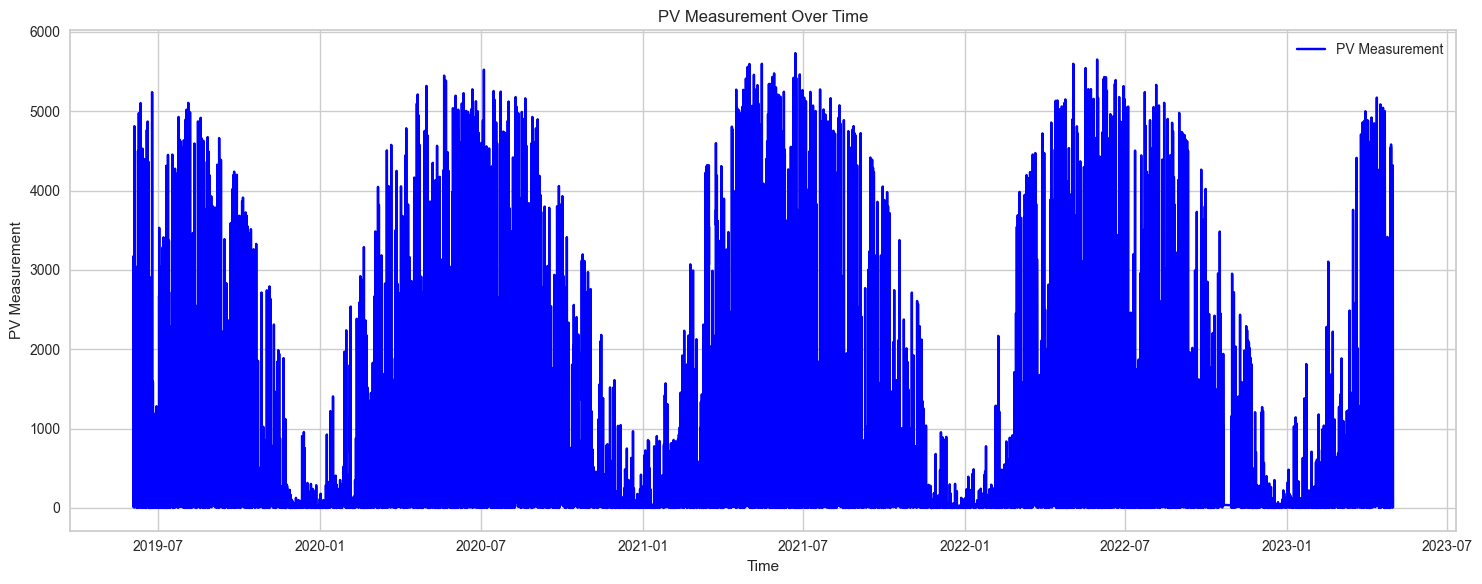

absolute_humidity_2m:gm3          float32
air_density_2m:kgm3               float32
ceiling_height_agl:m              float32
clear_sky_energy_1h:J             float32
clear_sky_rad:W                   float32
cloud_base_agl:m                  float32
dew_or_rime:idx                   float32
dew_point_2m:K                    float32
diffuse_rad:W                     float32
diffuse_rad_1h:J                  float32
direct_rad:W                      float32
direct_rad_1h:J                   float32
effective_cloud_cover:p           float32
fresh_snow_12h:cm                 float32
fresh_snow_1h:cm                  float32
fresh_snow_24h:cm                 float32
fresh_snow_3h:cm                  float32
fresh_snow_6h:cm                  float32
is_in_shadow:idx                  float32
msl_pressure:hPa                  float32
precip_5min:mm                    float32
precip_type_5min:idx              float32
pressure_100m:hPa                 float32
pressure_50m:hPa                  

TypeError: setup() got an unexpected keyword argument 'create_interactions'

In [38]:
locations = ['A', 'B', 'C']
all_predictions = []
final_df_list = [] 


for loc in locations:
    # Load your data
    train = pd.read_parquet(f'{loc}/train_targets.parquet').fillna(0)
    X_train_estimated = pd.read_parquet(f'{loc}/X_train_estimated.parquet')
    X_train_observed = pd.read_parquet(f'{loc}/X_train_observed.parquet')
    X_test_estimated = pd.read_parquet(f'{loc}/X_test_estimated.parquet')
    print(train,'pv_measurement')
    '''train_non_zero = train[train['pv_measurement'] != 0]
    if train_non_zero.empty:
        print(f"train_non_zero is empty for location {loc}")

    # Get the timestamps of these rows
    valid_timestamps = train_non_zero['time'].tolist()
    
    # Filter the X_* dataframes based on these timestamps
    X_train_estimated = X_train_estimated[X_train_estimated['date_forecast'].isin(valid_timestamps)]
    X_train_observed = X_train_observed[X_train_observed['date_forecast'].isin(valid_timestamps)]
    #X_test_estimated = X_test_estimated[X_test_estimated['date_forecast'].isin(valid_timestamps)]
    if X_train_estimated.empty:
        print(f"X_train_estimated is empty for location {loc}")'''

    #lage dag og måned feature der man aggregerer opp 
    # Preprocess data
    X_train, X_test, is_day_feature, targets = preprocessing(train, X_train_observed, X_train_estimated, X_test_estimated)
    y_train = targets
    if X_train.empty or len(y_train) == 0:
        print(f"X_train or y_train is empty for location {loc}")

    # Ensure X and y have the same length
    print(len(X_train), 'X')
    print(len(y_train),'y')
    min_length = min(len(X_train), len(y_train))
    X_train, y_train = X_train.iloc[:min_length], y_train[:min_length]
    
    # Process the location data and get the final model
    final_model = process_location(X_train, y_train, loc)
    # Predict on new data
    predictions = predict_model(final_model, data=X_test)
        #print(predictions.columns)
        # Assuming 'predictions' is the output from predict_model
    final_predictions = predictions['prediction_label']
    print(final_predictions.dtypes)
    print(is_day_feature.dtypes)
    # Multiply final predictions with the 'is_day:idx' values
    
    adjusted_final_predictions = final_predictions * is_day_feature['is_day:idx']
    adjusted_final_predictions = np.clip(adjusted_final_predictions, 0, None)
    # Now, 'adjusted_final_predictions' contains the adjusted target values.

        # Store predictions
    all_predictions.append(adjusted_final_predictions)  

        # Prepare dataframe for visualization
    num_predictions = len(predictions)
    timestamps = pd.date_range(start='2023-05-01 00:00:00', periods=num_predictions, freq='H')

    df = pd.DataFrame({
            'time': timestamps,
            'prediction': predictions['prediction_label'],
            'location': loc
        })

    final_df_list.append(df)


# Concatenate all the individual data frames and prepare for plotting
final_df = pd.concat(final_df_list, ignore_index=True)
final_df['time'] = pd.to_datetime(final_df['time'])
final_df.sort_values('time', inplace=True)

# Visualization
for loc in locations:
    # Filter data for each location
    temp_df = final_df[final_df['location'] == loc]
    
    plt.figure(figsize=(12, 6))  # Create a new figure for each location
    plt.plot(temp_df['time'], temp_df['prediction'], label=f'Location {loc}')
    plt.xlabel('Time')
    plt.ylabel('Predictions')
    plt.title(f'Predictions Over Time for Location {loc}')
    plt.legend()
    plt.show()

# If you need to save the final dataframe without 'time' and 'location' columns, you can do so before plotting
final_df_save = final_df.copy()
final_df_save = final_df_save.drop(columns=['time', 'location'])

In [ ]:
print(X_test.shape)


(720, 52)


In [ ]:
'''sample_submission = pd.read_csv('sample_submission.csv')
sample_submission
sample_submission = sample_submission[['id']].merge(final_df[['id', 'prediction']], on='id', how='left')
sample_submission.to_csv('my_first_submission.csv', index=False)'''

final_predictions = np.concatenate(all_predictions)

# Save the final_predictions to CSV
df = pd.DataFrame(final_predictions, columns=['prediction'])
df['id'] = df.index
df = df[['id', 'prediction']]
df.to_csv('final_predictions.csv', index=False)